## Hyperparameters optimization for SVC in the case of binary class (Sell, Buy)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold




In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", index_col = 0)["target"]

In [4]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [6]:
interest_rate = wk_df["r"].values

### EDA for exp_price file

[Open report](exp_price_report.html)

In [7]:
def display_report(y_test:np.ndarray, predictions:np.ndarray)->None:
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return

In [8]:
def plot_feature_imp(coefficients:np.ndarray[float], columns:list[str])->None:

    feature_importance = pd.DataFrame({'Feature': columns, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
    plt.show()
    return

In [9]:
def get_params()->dict:
    C = np.logspace(-2,2,30)
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    degree = [2,3,4,5,6,7,8]
    gamma = ["auto", "scale"]
    shrinking = [True, False]

    random_grid = {'svc__C': C,
                'svc__kernel': kernel,
                'svc__degree': degree,
                'svc__gamma': gamma,
                'svc__shrinking': shrinking, 
                'svc__random_state':[1968]
                }
    
    return random_grid

## Baseline Random Forest Classifier without new data + r

In [10]:
orig_df = ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff_date"]].copy()

In [11]:
orig_df["r"] = interest_rate

In [12]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [13]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('scaler', StandardScaler()),('svc', SVC())])

In [14]:
n_iter = 200
verbose_level = 1
n_jobs = 4
cv = StratifiedKFold(4)
random_grid = get_params()

In [15]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, 
                               param_distributions = random_grid, 
                               n_iter = n_iter, 
                               cv = cv, 
                               scoring="recall",
                               verbose=verbose_level, 
                               random_state=1968, 
                               n_jobs = n_jobs)

In [16]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'svc__C': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89...
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02]),
                                        'svc__degree': [2, 3, 4, 5, 6, 7, 8],
                                        'svc__gamma': ['auto', 'scale'],
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid'],
                                        'svc__random_state': [1968],
                                        'svc__shrinking': [True, False]},
                   random_state=1968, scoring='recall', verbose=1)

In [17]:
rf_random.best_params_

{'svc__shrinking': False,
 'svc__random_state': 1968,
 'svc__kernel': 'poly',
 'svc__gamma': 'scale',
 'svc__degree': 7,
 'svc__C': 3.039195382313198}

In [18]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__shrinking,param_svc__random_state,param_svc__kernel,param_svc__gamma,param_svc__degree,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
180,0.046203,0.006645,0.009511,0.002980,True,1968,poly,auto,7,3.039195,"{'svc__shrinking': True, 'svc__random_state': ...",0.850000,0.798319,0.873950,0.840336,0.840651,0.027333,1
162,0.068530,0.010864,0.008254,0.001257,False,1968,poly,scale,7,3.039195,"{'svc__shrinking': False, 'svc__random_state':...",0.850000,0.798319,0.873950,0.840336,0.840651,0.027333,1
185,0.042945,0.004125,0.009274,0.001773,True,1968,poly,auto,7,1.172102,"{'svc__shrinking': True, 'svc__random_state': ...",0.858333,0.815126,0.831933,0.831933,0.834331,0.015463,3
92,0.081921,0.026347,0.011208,0.001704,True,1968,poly,scale,8,7.880463,"{'svc__shrinking': True, 'svc__random_state': ...",0.783333,0.831933,0.823529,0.840336,0.819783,0.021867,4
52,0.086847,0.009280,0.010926,0.001764,False,1968,poly,scale,7,4.175319,"{'svc__shrinking': False, 'svc__random_state':...",0.816667,0.747899,0.857143,0.848739,0.817612,0.042989,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.040370,0.006616,0.031610,0.002074,False,1968,rbf,auto,4,0.013738,"{'svc__shrinking': False, 'svc__random_state':...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,184
170,0.033646,0.001474,0.033274,0.002496,False,1968,rbf,scale,5,0.035622,"{'svc__shrinking': False, 'svc__random_state':...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,184
147,0.035792,0.003323,0.028595,0.002643,True,1968,rbf,scale,3,0.035622,"{'svc__shrinking': True, 'svc__random_state': ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,184
68,0.037733,0.004718,0.014134,0.001216,True,1968,sigmoid,scale,8,0.025929,"{'svc__shrinking': True, 'svc__random_state': ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,184


In [19]:
best_model = rf_random.best_estimator_

In [20]:
best_model.score(X_test, y_test)

0.6095617529880478

In [21]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.70      0.36      0.47       123
           1       0.58      0.85      0.69       128

    accuracy                           0.61       251
   macro avg       0.64      0.60      0.58       251
weighted avg       0.64      0.61      0.58       251



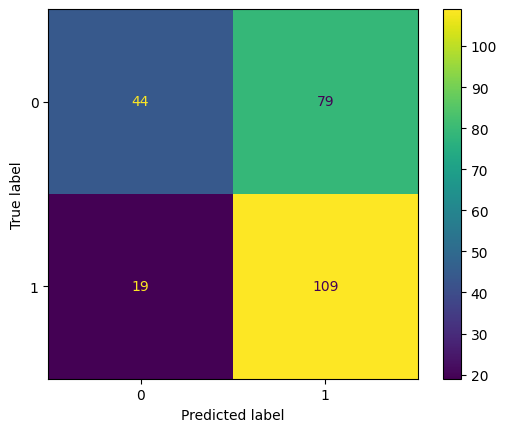

In [22]:
display_report(y_test, predictions)

### Test model

In [23]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=False)

In [24]:
rf_params = {k[5:]:v for k,v in rf_random.best_params_.items()} | {
 'verbose':1}

In [25]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('scaler', StandardScaler()), ('svc', SVC(**rf_params))])

In [26]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibSVM]......................

.............................................................................................................................................*
optimization finished, #iter = 163404
obj = -2476.555692, rho = 0.940187
nSV = 879, nBSV = 810
Total nSV = 879


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('svc',
                 SVC(C=3.039195382313198, degree=7, kernel='poly',
                     random_state=1968, shrinking=False, verbose=1))])

In [27]:
predictions = pipe.predict(X_test)

In [28]:
pipe.score(X_test, y_test)

0.4302788844621514

In [29]:
insample_preds = pipe.predict(X_train)

### Buy only strategy 

### in-sample

In [30]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(insample_preds)):
    row = orig_df.iloc[i,:].to_dict()
    quote_date = orig_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if insample_preds[i]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.0,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [31]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_date,final_price,profit,bare
Date,,,,,,,
2018-01-02,1,269.0,1.56,2018-01-24,283.179993,12.619993,12.619993
2018-01-03,1,270.0,2.15,2018-01-24,283.179993,11.029993,11.029993
2018-01-04,1,272.0,1.67,2018-01-24,283.179993,9.509993,9.509993
2018-01-05,1,273.0,2.21,2018-01-26,286.579987,11.369987,11.369987
2018-01-08,1,274.0,2.08,2018-01-31,281.899994,5.819994,5.819994
...,...,...,...,...,...,...,...
2021-12-27,0,477.0,5.76,2022-01-18,456.489990,0.000000,-5.760000
2021-12-28,0,477.0,5.29,2022-01-18,456.489990,0.000000,-5.290000
2021-12-29,0,478.0,5.43,2022-01-19,451.750000,0.000000,-5.430000


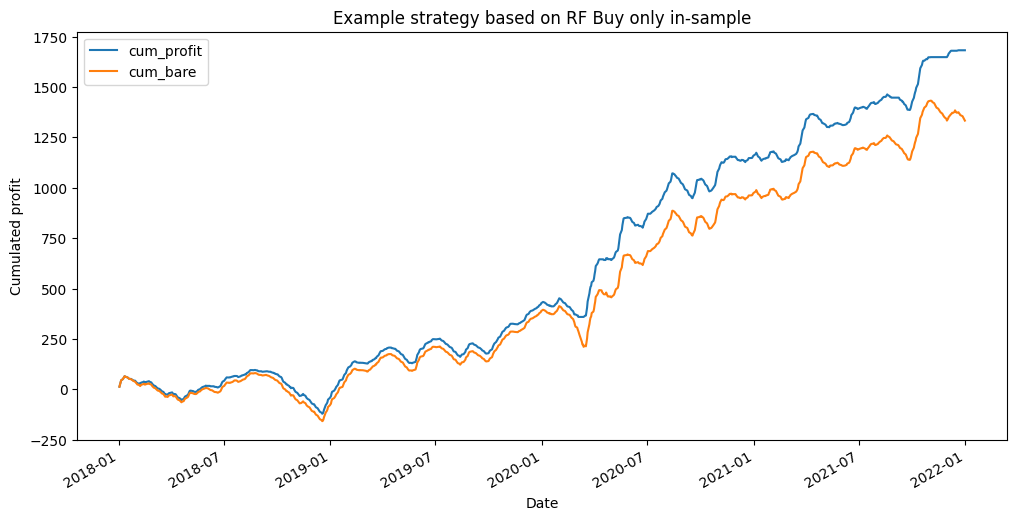

In [32]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only in-sample")
plt.legend()
plt.show()

### out-of-sample

In [33]:
strategy = []
date_idx = []
for x,i in enumerate(range(len(predictions),0,-1)):
    row = orig_df.iloc[-i,:].to_dict()
    quote_date = orig_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    final_price = spy.loc[exp_date,"Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:    
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [34]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_date,final_price,profit,bare
Date,,,,,,,
2022-01-03,0,478.0,4.81,2022-01-24,439.839996,0.00,-4.810000
2022-01-04,0,478.0,4.80,2022-01-24,439.839996,0.00,-4.800000
2022-01-05,0,468.0,8.14,2022-01-26,433.380005,0.00,-8.140000
2022-01-06,0,468.0,7.00,2022-01-26,433.380005,0.00,-7.000000
2022-01-07,0,466.0,7.56,2022-01-28,441.950012,0.00,-7.560000
...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,2023-01-13,398.500000,0.00,7.500000
2022-12-26,1,383.0,7.96,2023-01-13,398.500000,7.54,7.540000
2022-12-28,0,377.0,8.75,2023-01-20,395.880005,0.00,10.130005


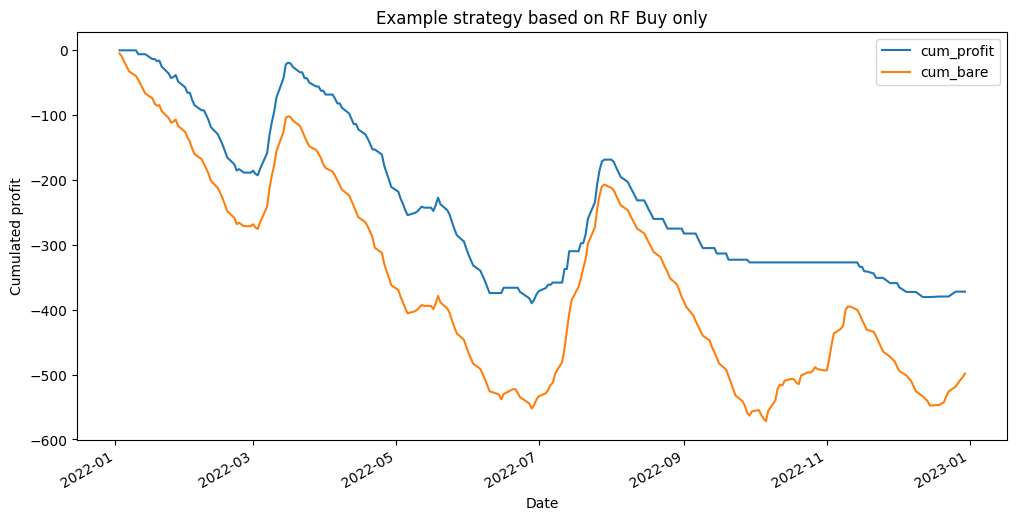

In [35]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only")
plt.legend()
plt.show()

## Random Forest with data from MC simulation and some addtional features

In [36]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [37]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"]-new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"]-new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"],2)
new_df["exp_profit"] = new_df["exp_price"]-(new_df["STRIKE"]+new_df["C_LAST"])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [39]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('scaler', StandardScaler()),('svc', SVC())])

In [40]:
n_iter = 200
verbose_level = 1
n_jobs = 4
cv = StratifiedKFold(4)
random_grid = get_params()

In [41]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, 
                               param_distributions = random_grid, 
                               n_iter = n_iter, 
                               cv = cv,
                               scoring="recall",
                               verbose=verbose_level, 
                               random_state=1968, 
                               n_jobs = n_jobs)

In [42]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'svc__C': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89...
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02]),
                                        'svc__degree': [2, 3, 4, 5, 6, 7, 8],
                                        'svc__gamma': ['auto', 'scale'],
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid'],
                                        'svc__random_state': [1968],
                                        'svc__shrinking': [True, False]},
                   random_state=1968, scoring='recall', verbose=1)

In [43]:
rf_random.best_params_

{'svc__shrinking': True,
 'svc__random_state': 1968,
 'svc__kernel': 'poly',
 'svc__gamma': 'scale',
 'svc__degree': 8,
 'svc__C': 5.736152510448681}

In [44]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__shrinking,param_svc__random_state,param_svc__kernel,param_svc__gamma,param_svc__degree,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
188,0.069708,0.004727,0.016563,0.002966,True,1968,poly,scale,8,5.736153,"{'svc__shrinking': True, 'svc__random_state': ...",0.800000,0.915966,0.899160,0.806723,0.855462,0.052492,1
133,0.049301,0.003996,0.013744,0.000746,True,1968,poly,auto,6,1.172102,"{'svc__shrinking': True, 'svc__random_state': ...",0.816667,0.915966,0.865546,0.798319,0.849125,0.045750,2
92,0.060902,0.002428,0.012832,0.001188,True,1968,poly,scale,8,7.880463,"{'svc__shrinking': True, 'svc__random_state': ...",0.791667,0.899160,0.890756,0.798319,0.844975,0.050126,3
186,0.086706,0.013070,0.015476,0.002394,False,1968,poly,scale,8,10.826367,"{'svc__shrinking': False, 'svc__random_state':...",0.800000,0.882353,0.873950,0.815126,0.842857,0.035820,4
102,0.073861,0.006167,0.018123,0.002227,True,1968,poly,auto,6,7.880463,"{'svc__shrinking': True, 'svc__random_state': ...",0.775000,0.840336,0.865546,0.831933,0.828204,0.033114,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.060857,0.006681,0.021100,0.005379,True,1968,sigmoid,auto,5,0.013738,"{'svc__shrinking': True, 'svc__random_state': ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,186
97,0.049896,0.001824,0.016957,0.001791,False,1968,sigmoid,auto,5,0.018874,"{'svc__shrinking': False, 'svc__random_state':...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,186
85,0.050862,0.002807,0.045960,0.007465,True,1968,rbf,scale,8,0.018874,"{'svc__shrinking': True, 'svc__random_state': ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,186
31,0.051088,0.002868,0.042865,0.003066,True,1968,rbf,auto,6,0.013738,"{'svc__shrinking': True, 'svc__random_state': ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,186


In [45]:
best_model = rf_random.best_estimator_

In [46]:
best_model.score(X_test, y_test)

0.6533864541832669

In [47]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.79      0.40      0.53       123
           1       0.61      0.90      0.73       128

    accuracy                           0.65       251
   macro avg       0.70      0.65      0.63       251
weighted avg       0.70      0.65      0.63       251



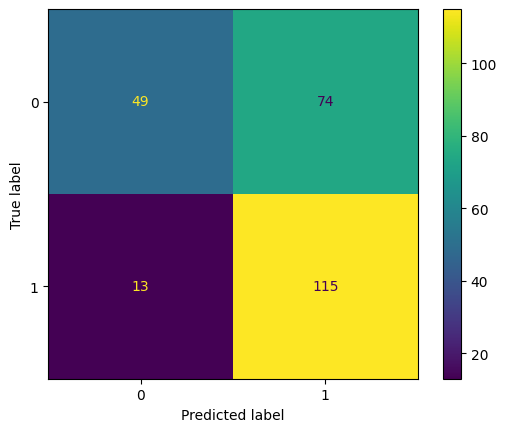

In [48]:
display_report(y_test, predictions)

### Test model

In [49]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=False)

In [53]:
rf_params = {k[5:]:v for k,v in rf_random.best_params_.items()} | {
 'verbose':1}

In [54]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('scaler', StandardScaler()), ('svc', SVC(**rf_params))])

In [55]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibSVM]..................*
optimization finished, #iter = 18806
obj = -4130.655608, rho = 0.911212
nSV = 856, nBSV = 715
Total nSV = 856


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('svc',
                 SVC(C=5.736152510448681, degree=8, kernel='poly',
                     random_state=1968, verbose=1))])

In [56]:
predictions = pipe.predict(X_test)

In [57]:
pipe.score(X_test, y_test)

0.44621513944223107

In [58]:
insample_preds = pipe.predict(X_train)

### Buy only strategy 

### in-sample

In [59]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(insample_preds)):
    row = new_df.iloc[i,:].to_dict()
    quote_date = new_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if insample_preds[i]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.0,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [60]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2018-01-02,1,269.0,1.56,4.795895,2018-01-24,283.179993,12.619993,12.619993
2018-01-03,1,270.0,2.15,4.898009,2018-01-24,283.179993,11.029993,11.029993
2018-01-04,1,272.0,1.67,4.327332,2018-01-24,283.179993,9.509993,9.509993
2018-01-05,1,273.0,2.21,4.899561,2018-01-26,286.579987,11.369987,11.369987
2018-01-08,1,274.0,2.08,4.865014,2018-01-31,281.899994,5.819994,5.819994
...,...,...,...,...,...,...,...,...
2021-12-27,0,477.0,5.76,11.573253,2022-01-18,456.489990,0.000000,-5.760000
2021-12-28,0,477.0,5.29,11.027398,2022-01-18,456.489990,0.000000,-5.290000
2021-12-29,0,478.0,5.43,10.748298,2022-01-19,451.750000,0.000000,-5.430000


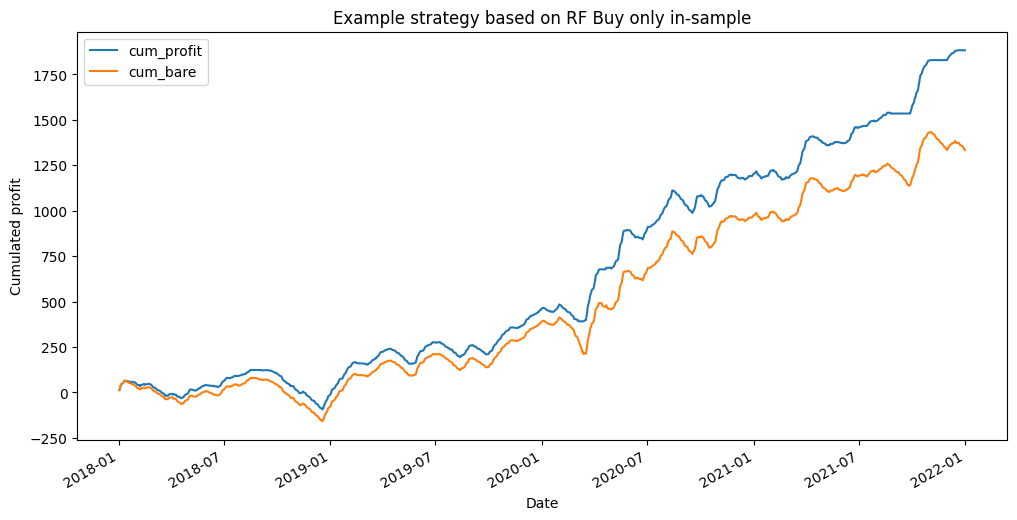

In [61]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only in-sample")
plt.legend()
plt.show()

### out-of-sample

In [62]:
strategy = []
date_idx = []
for x,i in enumerate(range(len(predictions),0,-1)):
    row = new_df.iloc[-i,:].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    final_price = spy.loc[exp_date,"Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:    
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [63]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2022-01-03,1,478.0,4.81,10.248337,2022-01-24,439.839996,-4.810000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.140000,-8.140000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000
2022-01-07,0,466.0,7.56,9.927762,2022-01-28,441.950012,0.000000,-7.560000
...,...,...,...,...,...,...,...,...
2022-12-23,1,383.0,8.00,8.453400,2023-01-13,398.500000,7.500000,7.500000
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,7.540000,7.540000
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005


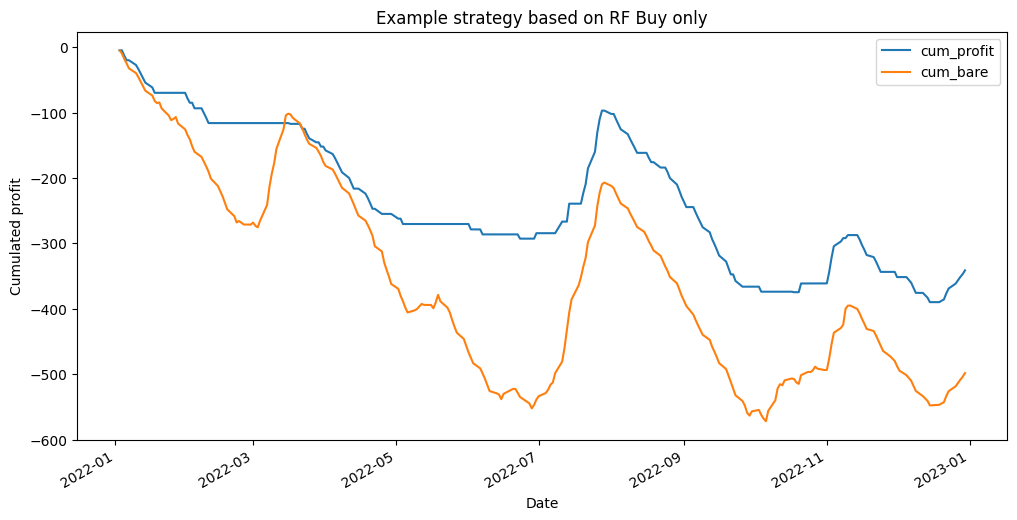

In [64]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only")
plt.legend()
plt.show()